In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   236M      0  0:00:03  0:00:03 --:--:--  236M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip


replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
log_dir = "logs/"
BATCH_SIZE = 32
BUFFER_SIZE = 1000
images_shape = [224, 224, 3]
images_size = (224, 224)
input_size = (224, 224, 3)
embedding_size = 64
class_count = 2
EPOCHS = 1
data_dir = './PetImages'

In [ ]:
def load_data(val=0.5):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=val,
                                                                   subset="training", seed=123,
                                                                   image_size=images_size, batch_size=BATCH_SIZE)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=val, 
                                                                 subset="validation", seed=123,
                                                                 image_size=images_size, batch_size=BATCH_SIZE)

    return train_ds, val_ds

In [ ]:
def load_model(name, freeze_percent):
    if name=='vgg16':
        mod = tf.keras.applications.VGG16
        preprocess_input = tf.keras.applications.vgg16.preprocess_input

    elif name=='resnet':
        mod = tf.keras.applications.ResNet50
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
    else:
        mod = tf.keras.applications.DenseNet121
        preprocess_input = tf.keras.applications.densenet.preprocess_input

    base_model = mod(input_shape=images_shape, include_top=False, weights='imagenet')


    freeze_layers = int(freeze_percent * len(base_model.layers))


    print(len(base_model.layers[:-freeze_layers]))

    for layer in base_model.layers[:-freeze_layers]:
        layer.trainable = False

    if (freeze_percent == 0.0):
        for layer in base_model.layers[:]:
            layer.trainable = False

    inputs = tf.keras.Input(shape=input_size)
    model = preprocess_input(inputs)
    model = base_model(model)
    model = layers.Flatten()(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.5)(model)
    feature = layers.Dense(64, activation=None, name='feature')(model)

    after = tf.keras.layers.Activation('relu')(feature)

    outputs = layers.Dense(1, name='classification')(after)
    model = tf.keras.Model(inputs, outputs)

    feature_model = tf.keras.Model(inputs, feature)

    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
                metrics=['accuracy'])

    return model, feature_model

In [ ]:
def train(name, freeze_percent):
    train_ds, val_ds = load_data()
    model, feature_model = load_model(name=name, freeze_percent=freeze_percent)
    
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

    return feature_model, history

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score


def random_forest(f):
    clf = RandomForestClassifier(warm_start=True, random_state=0, n_estimators = 1, max_depth=10)

    for image, label in train_ds_random_forest.take(-1):
        features = f.predict(image, verbose=0)
        clf.fit(features, label)
        clf.n_estimators+=1
    pred_=np.array([])
    labels_=np.array([])

    for image, label in val_ds_random_forest.take(-1):
        features = f.predict(image, verbose=0)
        pred = clf.predict(features)
        pred_ = np.concatenate([pred_, pred])
        labels_ = np.concatenate([labels_, label.numpy()])
    
    return accuracy_score(labels_, pred_)

In [ ]:
train_ds_random_forest, val_ds_random_forest = load_data(val=0.5)

for m in ['vgg16', 'resnet', 'densenet']:
    for freeze_percent in [0.1, 0.3, 0.5, 0.7, 1.0]:
        feature_model, history = train(m, freeze_percent)
        if (freeze_percent == 0.3):
            random_forest_acc = random_forest(feature_model)
            print(random_forest_acc)

Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.
Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.
18
366/366 [==============================] - 108s 274ms/step - loss: 0.5359 - accuracy: 0.9440 - val_loss: 0.1330 - val_accuracy: 0.9778
Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.
14
366/366 [==============================] - 110s 292ms/step - loss: 0.2152 - accuracy: 0.9450 - val_loss: 0.0707 - val_accuracy: 0.9775
0.9745407945322512
Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.
10
366/366 [==============================] - 130s 341ms/step - loss: 0.2167 - accuracy: 0.9259 - val_los

In [ ]:
for m in ['vgg16', 'resnet', 'densenet']:
    f_, h_ = train(m, 0.0)

Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.
0
366/366 [==============================] - 100s 269ms/step - loss: 0.5141 - accuracy: 0.9470 - val_loss: 0.1458 - val_accuracy: 0.9753
Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.
94765736/94765736 [==============================] - 0s 0us/step
0
366/366 [==============================] - 81s 206ms/step - loss: 0.1631 - accuracy: 0.9695 - val_loss: 0.0867 - val_accuracy: 0.9800
Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.
29084464/29084464 [==============================] - 0s 0us/step
0
366/366 [==============================] - 86s 209ms/step - loss: 0.0804 - accuracy: 0.9754 - val_loss: 0.0462 - val_accuracy: 0.9836


In [ ]:
histories = []
EPOCHS = 5
for m in ['vgg16', 'resnet', 'densenet']:
    f_, h_ = train(m, 0.3)
    histories.append(h_)

Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.
14
Epoch 1/5
366/366 [==============================] - 109s 290ms/step - loss: 0.2200 - accuracy: 0.9478 - val_loss: 0.0761 - val_accuracy: 0.9665
Epoch 2/5
366/366 [==============================] - 105s 286ms/step - loss: 0.0553 - accuracy: 0.9805 - val_loss: 0.0805 - val_accuracy: 0.9780
Epoch 3/5
366/366 [==============================] - 105s 286ms/step - loss: 0.0354 - accuracy: 0.9862 - val_loss: 0.1147 - val_accuracy: 0.9758
Epoch 4/5
366/366 [==============================] - 140s 382ms/step - loss: 0.0349 - accuracy: 0.9891 - val_loss: 0.0895 - val_accuracy: 0.9651
Epoch 5/5
366/366 [==============================] - 105s 286ms/step - loss: 0.0366 - accuracy: 0.9874 - val_loss: 0.0999 - val_accuracy: 0.9815
Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 

Text(0.5, 0, 'epoch')

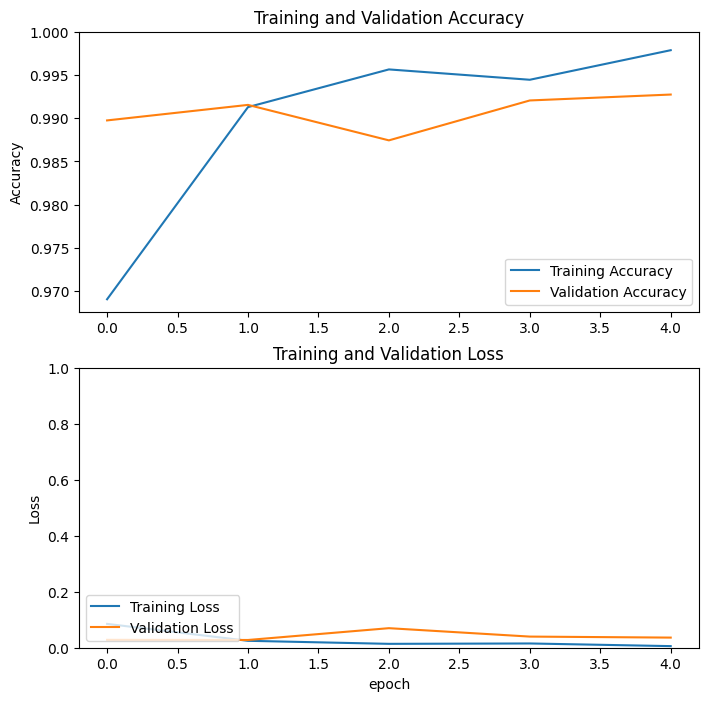

In [ ]:
acc=histories[2].history['accuracy']
val_acc = histories[2].history['val_accuracy']

loss = histories[2].history['loss']
val_loss = histories[2].history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.plot(triplet_loss, label='Training Triplet Loss')
# plt.plot(triplet_val_loss, label='Validation Triplet Loss')
plt.legend(loc='lower left')
plt.ylabel('Loss')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [ ]:
!pip install tensorflow_decision_forests

In [ ]:
import tensorflow_decision_forests as tfdf
train_ds_random_forest, val_ds_random_forest = load_data(val=0.5)


Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.


In [ ]:
f_, h_ = train('vgg16', 0.3)

Found 23410 files belonging to 2 classes.
Using 11705 files for training.
Found 23410 files belonging to 2 classes.
Using 11705 files for validation.
14
366/366 [==============================] - 114s 302ms/step - loss: 0.1911 - accuracy: 0.9448 - val_loss: 0.0663 - val_accuracy: 0.9739


In [ ]:
labels = np.array([])
for i in range(10):
    for image, label in val_ds_random_forest.take(1):
        feature = f_(image)
        if i == 0:
            features = feature
        else:
            features = np.concatenate([features, feature])
        labels = np.concatenate([labels, label.numpy()])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
a = pca.fit_transform(features)

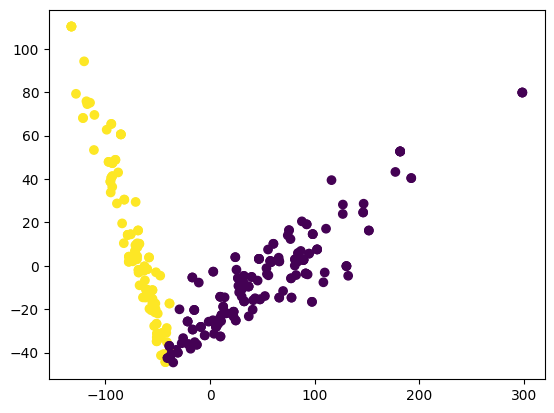

In [ ]:
plt.scatter(a[:, 0], a[:, 1], c=labels)